# Ciruculation Insights

This notebook will begin to explore the circulation data to find how it aligns with the WIM data. In particular it will look into the following distances between cars and trucks, the headway and the likelihood that a car is between trucks. This is in addition to general trends looked into by the data.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.rc('figure',figsize=(12,8))

In [2]:
station = 137
year = 2017

In [27]:
df_all = pd.read_pickle('{}/{}_circ.pkl'.format(station, year))

In [28]:
df_all.head()

,z,Lane,Dir,Headway,IVT,Speed,Length,SwissT,Time,Date,index
0,0.0,5,1,99.9,99.9,109.0,384.0,3,0.020564,2017-01-01 00:01:14.003,0
1,0.0,2,1,99.9,99.9,110.0,518.0,3,0.023911,2017-01-01 00:01:26.008,1
2,0.0,5,1,13.9,13.8,112.0,379.0,3,0.024450,2017-01-01 00:01:28.002,2
3,0.0,5,1,0.6,0.5,115.0,448.0,3,0.024636,2017-01-01 00:01:28.069,3
4,0.0,5,1,7.5,7.4,116.0,426.0,3,0.026739,2017-01-01 00:01:36.026,4


In [29]:
heavy = [1, 8, 9, 10]
light = range(2, 8)

In [30]:
#Filter for the slow lanes
df_all = df_all[df_all.Lane.isin([1, 5])] #Change for only single lane

In [43]:
df_light = df_all[df_all['SwissT'].isin(light)]

In [9]:
def reindex_series(df):
    df['DateHour'] = df.Date.dt.round('H')
    df = df.set_index(df.DateHour)
    new_idx = pd.date_range(df.index[0].date(), df.index[-1].date(), freq='H')
    df = df.drop(columns='DateHour')
    df = df.groupby('DateHour').Date.count()
    df = df.reindex(new_idx).groupby(lambda x: x.date()).filter(lambda x: x.isnull().sum() < 24)
    df = df.fillna(0)
    df = df.reindex(new_idx) #Remove the filter so that the Nans remain
    return df

In [37]:
def print_plots(series_values, lags):
    series_values.plot()
    plot_acf(series_values, lags=lags)
    plt.show()
    plot_pacf(series_values, lags=lags)
    plt.show()

In [44]:
df_light = reindex_series(df_light)

C:\Users\Isabelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
df_all = reindex_series(df_all)

In [79]:
df_light

2017-01-01 00:00:00     70.0
2017-01-01 01:00:00    477.0
2017-01-01 02:00:00    486.0
2017-01-01 03:00:00    331.0
2017-01-01 04:00:00    244.0
                       ...  
2017-12-31 20:00:00    489.0
2017-12-31 21:00:00    273.0
2017-12-31 22:00:00    239.0
2017-12-31 23:00:00    216.0
2018-01-01 00:00:00     85.0
Freq: H, Name: Date, Length: 8761, dtype: float64

In [59]:
all_diff = df.diff(168).fillna(0)

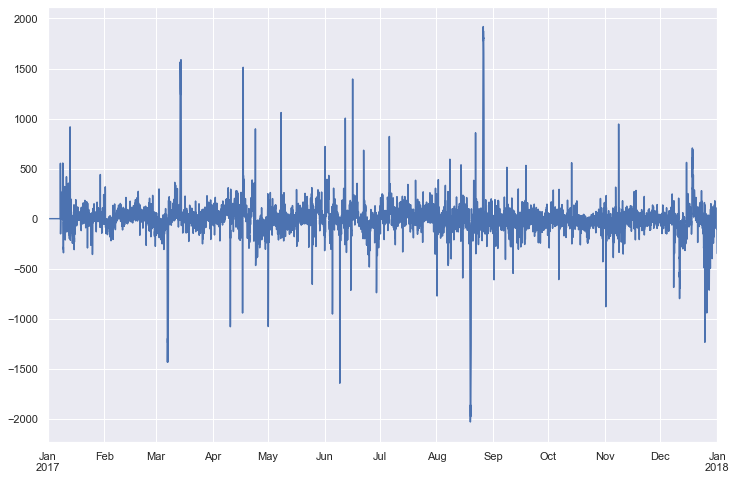

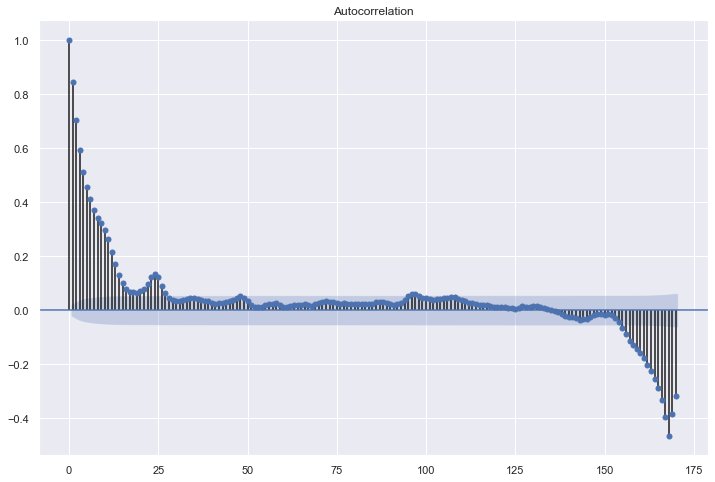

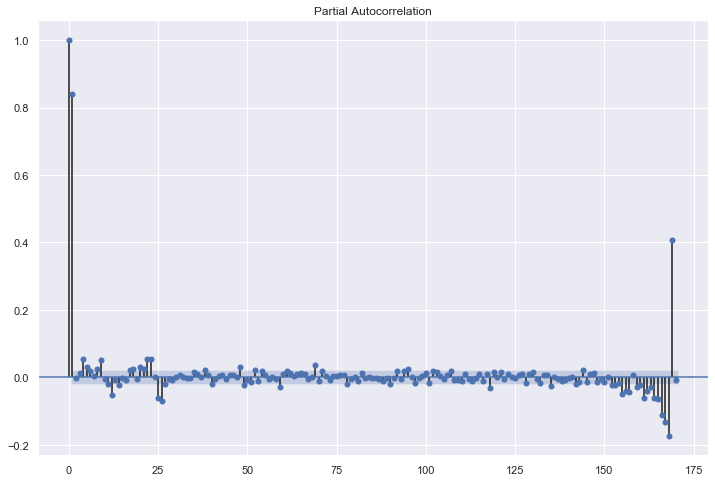

In [60]:
print_plots(all_diff, 170)

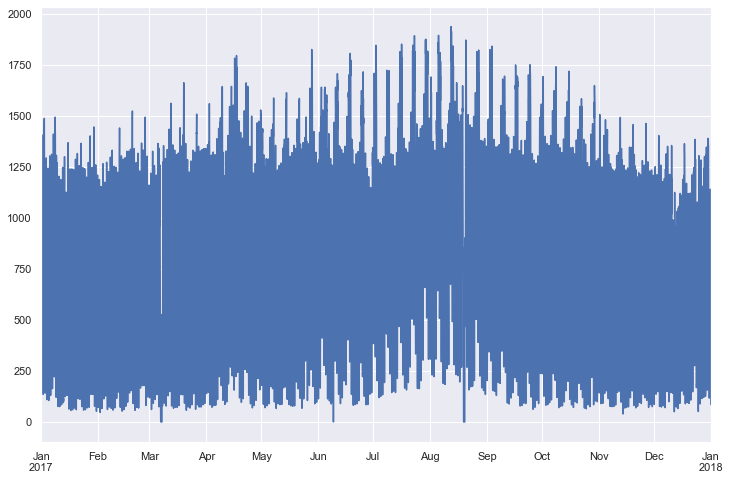

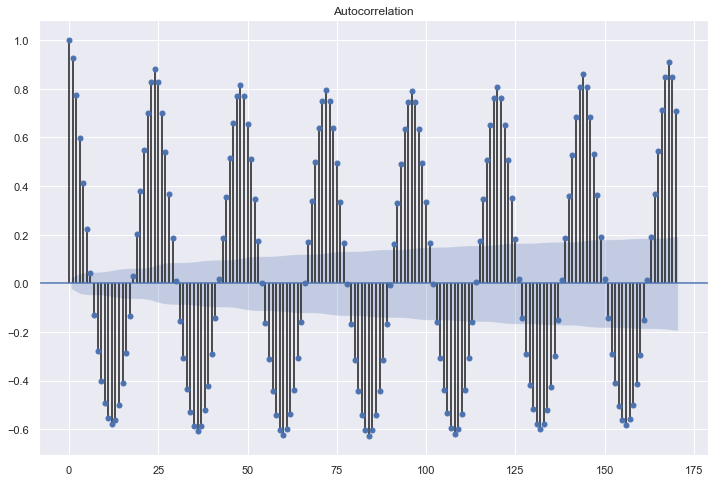

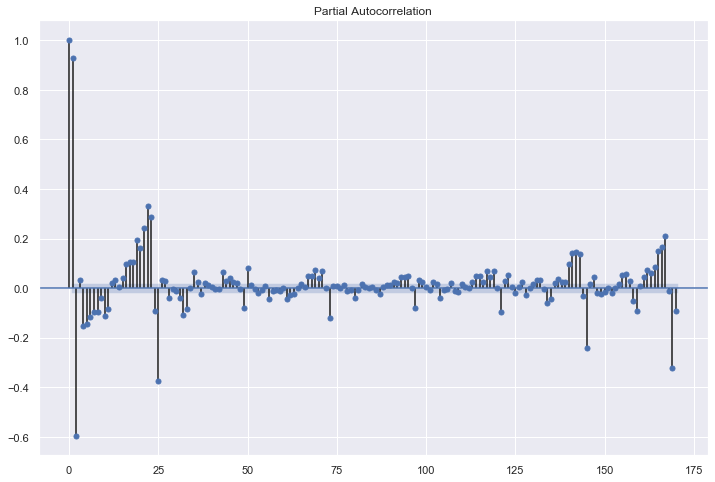

In [38]:
print_plots(df_light, 170)

In [39]:
diff = df_light.diff(168).fillna(0)

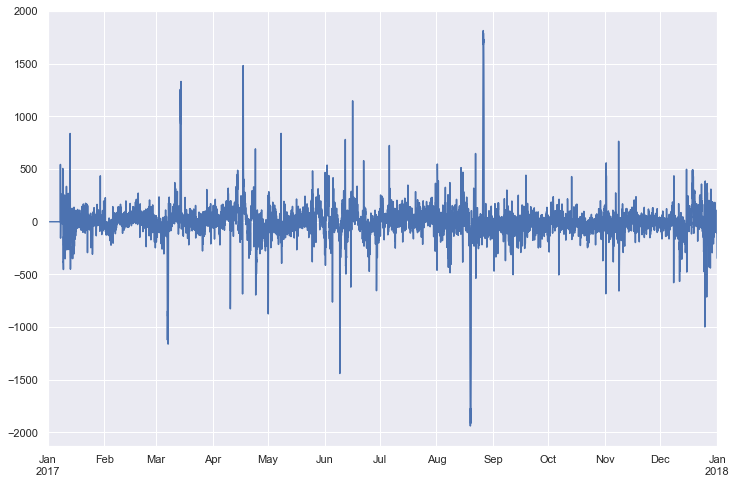

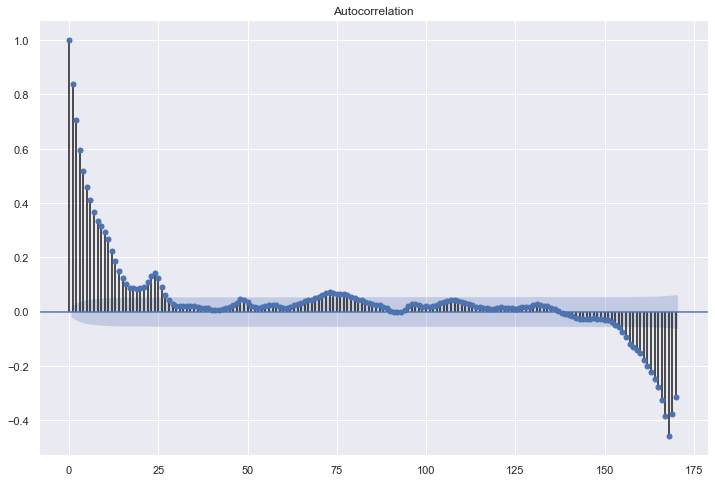

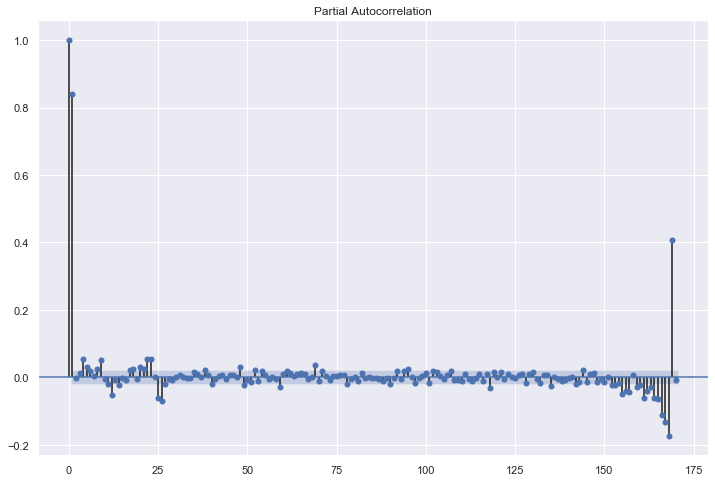

In [40]:
print_plots(diff, 170)

In [56]:
pad_idx =  pd.date_range(df_nan.index[0].date() - pd.Timedelta('7 day'), df.index[-1].date(), freq='H') #Pad so that the week seasonality can be manually subtracted

In [11]:
def print_plots(series_values, lags):
    series_values.plot()
    plot_acf(series_values, lags=lags)
    plt.show()
    plot_pacf(diff, lags=lags)
    plt.show()

In [11]:
swiss_holiday = holidays.CountryHoliday('CH')

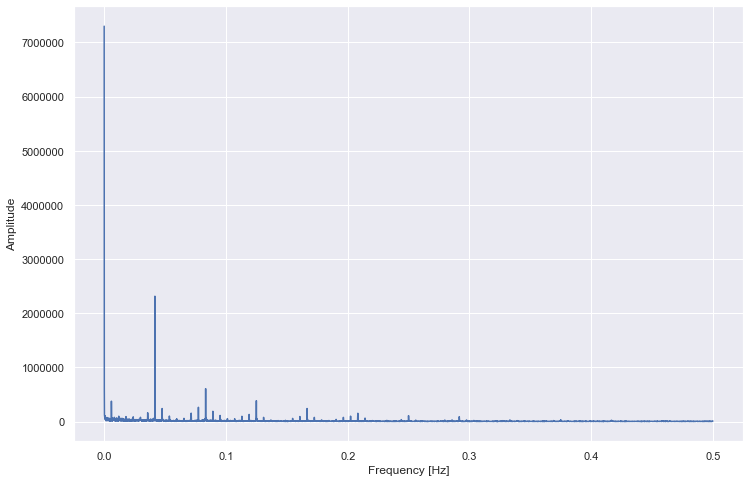

In [93]:
N = df_light.shape[0] #number of elements
t = np.linspace(0, N * 3600, N) #converting hours to seconds


fft_hour = np.fft.rfft(df_light)
fftfreq = np.fft.rfftfreq(len(df_light))

T = t[1] - t[0]

f = np.linspace(0, 1 / T, N)
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.plot(fftfreq,abs(fft_hour))
plt.show()

In [94]:
abs_fft = pd.concat([pd.Series(fftfreq), pd.Series(abs(fft_hour))], axis=1)

In [95]:
abs_fft.columns = ['FFT_Freq', 'Abs_FFT']

In [96]:
abs_fft['period'] = 1/abs_fft.FFT_Freq

In [97]:
abs_fft.nlargest(5, 'Abs_FFT')

,FFT_Freq,Abs_FFT,period
0,0.000000,7.301027e+06,inf
365,0.041662,2.314182e+06,24.002740
730,0.083324,6.069093e+05,12.001370
1,0.000114,6.068987e+05,8761.000000
1095,0.124986,3.846355e+05,8.000913


In [39]:
from scipy import signal
import matplotlib.pyplot as plt

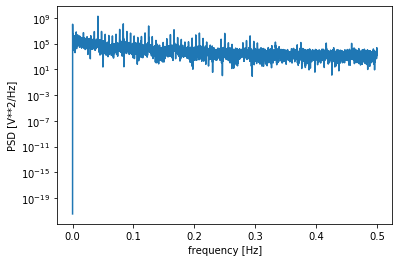

In [43]:
f, Pxx_den = signal.periodogram(df_norm)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

C:\Users\Isabelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


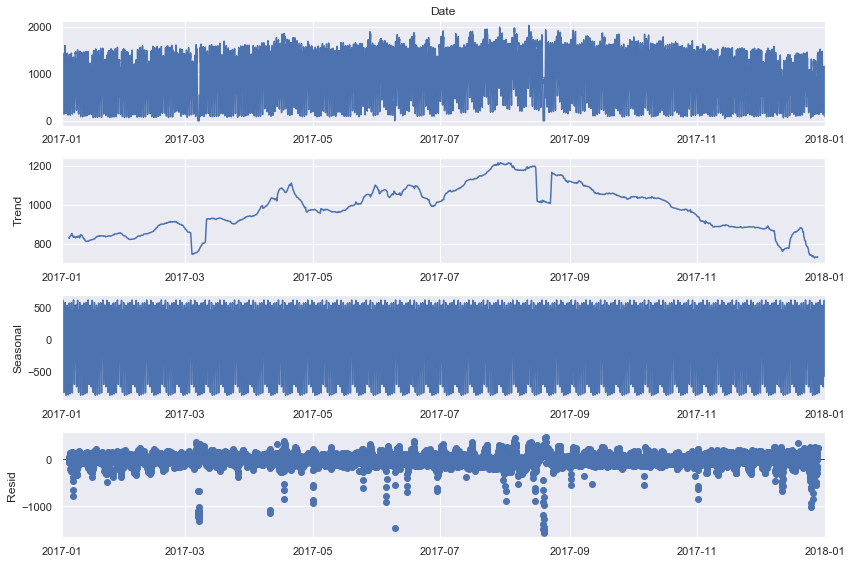

In [57]:
result = seasonal_decompose(df_nan, model='additive',freq=168)
fig = result.plot()

In [40]:
df_no_week = df_nan.diff(168)

C:\Users\Isabelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


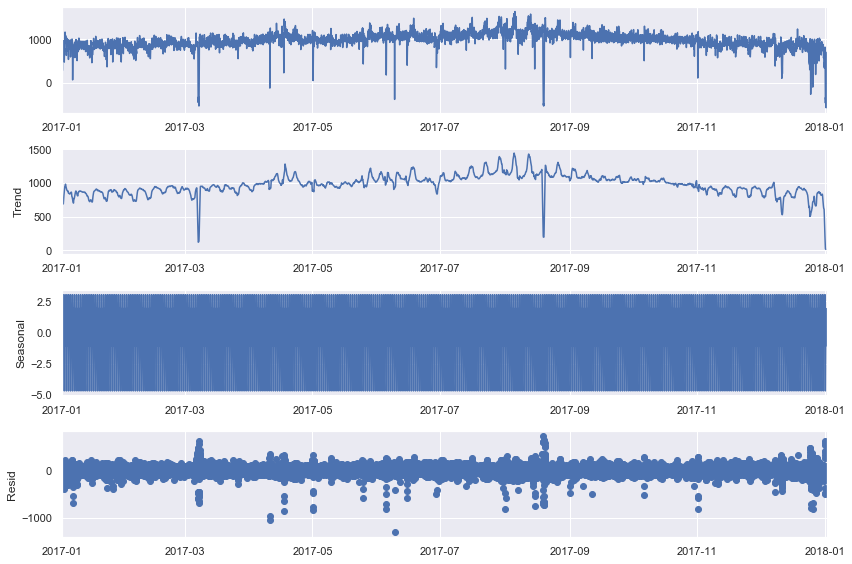

In [97]:
result = seasonal_decompose(df_no_week, model='additive',freq=24)
fig = result.plot()

In [41]:
df_no_day = df_no_week.diff(24)

In [43]:
df_no_day= df_no_day.fillna(0)

C:\Users\Isabelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


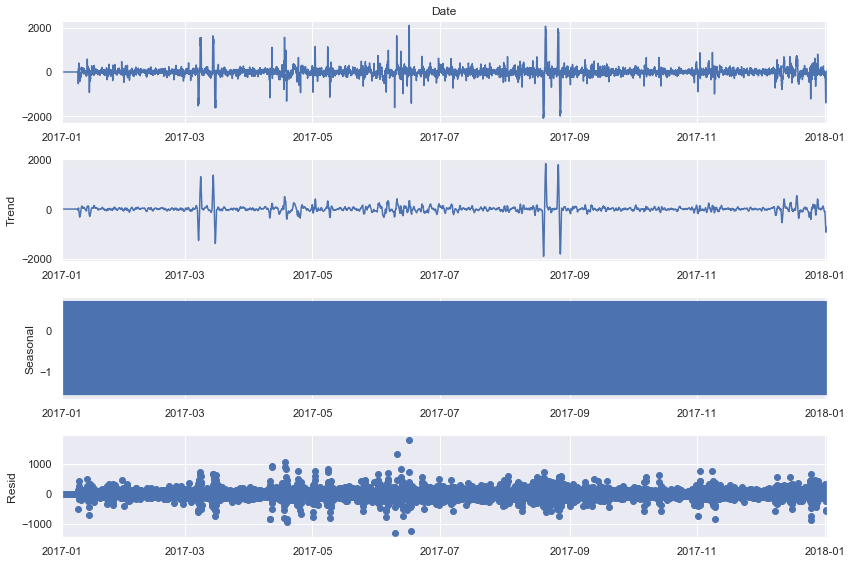

In [44]:
result = seasonal_decompose(df_no_day, model='additive',freq=12)
fig = result.plot()

In [70]:
pm.arima.ndiffs(df_no_week)

1

In [99]:
df_diff = df_no_day.diff()

In [100]:
df_diff = df_diff.fillna(0)

In [101]:
#Dickey-Fuller test:
adfTest = adfuller(diff)

pvalue = adfTest[1]

In [102]:
pvalue #Reject the null, it is stationary

7.93683320756975e-27

In [103]:
adfTest

(-14.420154434949513,
 7.93683320756975e-27,
 26,
 8734,
 {'1%': -3.4310989378240957,
  '5%': -2.8618709806843423,
  '10%': -2.5669461760495387},
 103373.52049093234)

In [12]:
# We can add multiple fourer series with different k terms - (2*k*pi) such as k=1,2,3...etc. To generalize the problem, 
# we could have chosen an optimal k value for each season by trying out some k values and choosing the values giving 
# the lowest AIC score.

def add_fourier_terms(df, year_k, half_day_k, week_k, day_k):
    """
    df: dataframe to add the fourier terms to 
    year_k: the number of Fourier terms the year period should have. Thus the model will be fit on 2*year_k terms (1 term for 
            sine and 1 for cosine)
    week_k: same as year_k but for weekly periods
    day_k:  same as year_k but for daily periods
    """
    
    terms_df =df.copy()
    
    for k in range(1, year_k+1):
        # year has a period of 365.25 including the leap year
        terms_df['year_sin'+str(k)] = np.sin(2 *k* np.pi * terms_df.index.dayofyear/365.25) 
        terms_df['year_cos'+str(k)] = np.cos(2 *k* np.pi * terms_df.index.dayofyear/365.25)

    for k in range(1, half_day_k+1):
        
        # week has a period of 7
        terms_df['half_sin'+str(k)] = np.sin(2 *k* np.pi * terms_df.index.hour/12)
        terms_df['half_cos'+str(k)] = np.cos(2 *k* np.pi * terms_df.index.hour/12)

    for k in range(1, week_k+1):
        
        # week has a period of 7
        terms_df['week_sin'+str(k)] = np.sin(2 *k* np.pi * terms_df.index.dayofweek/7)
        terms_df['week_cos'+str(k)] = np.cos(2 *k* np.pi * terms_df.index.dayofweek/7)

    for k in range(1, day_k+1):
        
        # day has period of 24
        terms_df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * terms_df.index.hour/24)
        terms_df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * terms_df.index.hour/24) 

    terms_df = terms_df.drop(columns='Date')
    return terms_df

In [96]:
import pmdarima as pm
#I want to find the optimal fouier orders to include for each of the seasonalities, year, day, week
#to find this I loop through combinations of fourier 
aic_values = []
k_values =  []
k_half = 4
k_day = 5
k_year = 4
for k_week in range(4, 6):
    test_df = add_fourier_terms(df, k_year, k_half, k_week, k_day)
    model = pm.auto_arima(df, D=0, max_P=0, max_Q=0,start_P=0,start_Q=0, stepwise=True, exogenous=test_df)
    aic_values.append(model.aic())
    k_values.append((k_half, k_day, k_week, k_year))
    print("{} half, {} day, {} week, {} year, {} aic".format(k_half, k_day, k_week, k_year, model.aic()))

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

4 half, 5 day, 4 week, 4 year, 105935.29067621767 aic


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KeyboardInterrupt: 

In [49]:
def train_test(df):
    df = df.to_frame()
    terms_df = add_fourier_terms(df, 0, 0, 0, 5) #Smallest AIC value 4 half, 5 day, 3 week, 4 year
    terms_df['Date'] = terms_df.index.date
    terms_df['holiday'] = terms_df['Date'].isin(swiss_holiday)
    terms_df = terms_df.drop(columns='Date')
    df = pd.concat([df, terms_df], axis=1)
    df['holiday'] = df.holiday.astype(float)
    test = df.tail(336)
    train = df.head(df.shape[0]-336)
    return test, train

In [50]:
test, train = train_test(df_light)

In [57]:
all_test, all_train = train_test(df_all)

In [113]:
# Creating the training and test datasets

# The code below can be used to train and find the optimal SARIMAX model parameters p,q,P,Q. 
#This was run and the optimal model was found to be SARIMAX(2,0,0)x(1,0,0,24). The auto regressive term p=2 means 
#two values from the past (1 and 2 hours behind) will be used and moving average term of q=1 means 1 past term will be used as 
# the moving average term. d=1 term means the energy series will differenced once to make it stationary. 
# Seasonal period m of 24 hours here and P=Q=1 means the auto regressive term (P) and the moving average (Q) exactly 1*24 hours 
# behind will be used.

results = pm.auto_arima(df['Date'], #data
                    d=0, # non-seasonal difference order
                    start_p=1, # initial guess for p
                    start_q=0, # initial guess for q
                    max_p=3, # max value of p to test
                    max_q=2, # max value of q to test
                    exogenous= df.drop(columns='Date'), #including the exogenous variables
                    seasonal=True, # is the time series seasonal? YES
                    m = 168, # the seasonal period
                    D = 1,
                    start_P=1, # initial guess for P
                    start_Q=0, # initial guess for Q
                    max_P=3, # max value of P to test
                    max_Q=2, # max value of Q to test
                    information_criterion='aic', # used to select best model
                    trace=True, # print results whilst training
                    stepwise=True, # apply intelligent order search
                    )


Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [ ]:
_= results.plot_diagnostics(figsize=(12, 7))

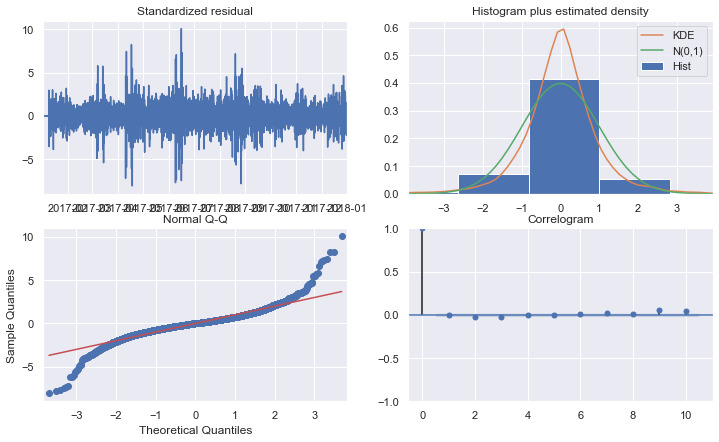

In [81]:
_= results.plot_diagnostics(figsize=(12, 7))

In [71]:
#For all traffic data

for q_ in range(0, 2):
    for Q_ in range(0, 2):
        for p_ in range(0, 3):
            for P_ in range(1, 4):
                model_opt = ARIMA(train['Date'], order=(p_,0,q_), seasonal_order=(P_, 1, Q_, 168), exog = train.drop(columns='Date'), trend='c')
                results = model_opt.fit(method='innovations_mle', low_memory=True, cov_type='none')
                print('({}, 0, {})({}, 1, {}), aic={}'.format(p_, q_, P_, Q_, results.aic))


(0, 0, 0)(1, 1, 0), aic=107243.02854385808
(0, 0, 0)(2, 1, 0), aic=106701.52586963604


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(0, 0, 0)(3, 1, 0), aic=106528.5147945062


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(1, 0, 0)(1, 1, 0), aic=96609.40324978395


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(1, 0, 0)(2, 1, 0), aic=96017.13914522075


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(1, 0, 0)(3, 1, 0), aic=95734.87164861827


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(2, 0, 0)(1, 1, 0), aic=96606.7317558939


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'
C:\Users\Isabelle\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


(2, 0, 0)(2, 1, 0), aic=96012.12118804861


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(2, 0, 0)(3, 1, 0), aic=95725.43147501451


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(0, 0, 0)(1, 1, 1), aic=106346.19573928679


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(0, 0, 0)(2, 1, 1), aic=106348.18118123965


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(0, 0, 0)(3, 1, 1), aic=106348.03479332922
(1, 0, 0)(1, 1, 1), aic=95215.71863595236


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(1, 0, 0)(2, 1, 1), aic=95185.35641645867


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(1, 0, 0)(3, 1, 1), aic=95176.15121142147


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(2, 0, 0)(1, 1, 1), aic=95206.43831837329


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(2, 0, 0)(2, 1, 1), aic=95177.55669918197


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(2, 0, 0)(3, 1, 1), aic=95171.2234592649


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(0, 0, 1)(1, 1, 0), aic=101353.17355195919


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(0, 0, 1)(2, 1, 0), aic=100779.95161356611


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(0, 0, 1)(3, 1, 0), aic=100567.37787316059


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(1, 0, 1)(1, 1, 0), aic=96606.46408885755


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(1, 0, 1)(2, 1, 0), aic=96011.82588678443


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(1, 0, 1)(3, 1, 0), aic=95725.14217742204


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(2, 0, 1)(1, 1, 0), aic=96607.15466381071


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(2, 0, 1)(2, 1, 0), aic=96013.04130400743


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


KeyboardInterrupt: 

In [38]:
#For small vehicle traffic data

for q_ in range(0, 2):
    for Q_ in range(0, 2):
        for p_ in range(0, 3):
            for P_ in range(1, 4):
                model_opt = ARIMA(train['Date'], order=(p_,0,q_), seasonal_order=(P_, 1, Q_, 168), exog = train.drop(columns='Date'), trend='c')
                results = model_opt.fit(method='innovations_mle', low_memory=True, cov_type='none')
                print('({}, 0, {})({}, 1, {}), aic={}'.format(p_, q_, P_, Q_, results.aic))
                aic.append(results.aic)

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(0, 0, 0)(1, 1, 0), aic=106110.09965837485
(0, 0, 0)(2, 1, 0), aic=105640.86213564036


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(0, 0, 0)(3, 1, 0), aic=105495.03885367792


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(1, 0, 0)(1, 1, 0), aic=95632.47134689234


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(1, 0, 0)(2, 1, 0), aic=95042.17720658556


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(1, 0, 0)(3, 1, 0), aic=94769.52128285923


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(2, 0, 0)(1, 1, 0), aic=95633.89074700823


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(2, 0, 0)(2, 1, 0), aic=95044.17626117433


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(2, 0, 0)(3, 1, 0), aic=94770.90554727237


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(0, 0, 0)(1, 1, 1), aic=105323.55113509453


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


(0, 0, 0)(2, 1, 1), aic=105322.03570937914


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


KeyboardInterrupt: 

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


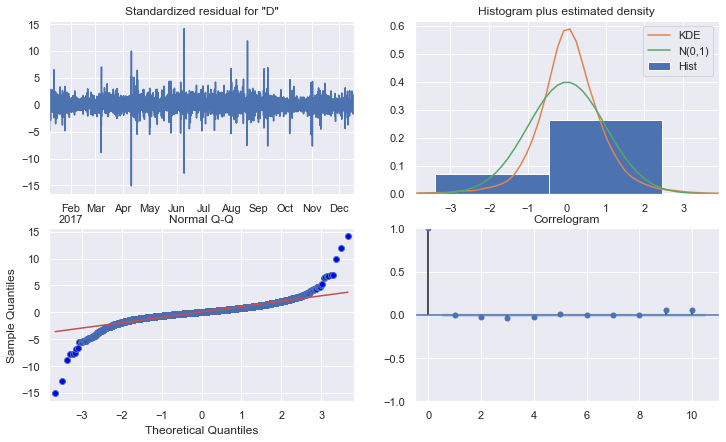

In [59]:
#Best model for overall traffic: (2, 0, 0)(3, 1, 1), aic=95171.2234592649
model_opt = ARIMA(all_train['Date'], order=(2,0,0), seasonal_order=(3, 1, 1, 168), exog = all_train.drop(columns='Date'), trend='c')
results = model_opt.fit(method='innovations_mle', low_memory=True, cov_type='none')
_ = results.plot_diagnostics(figsize=(12, 7))

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


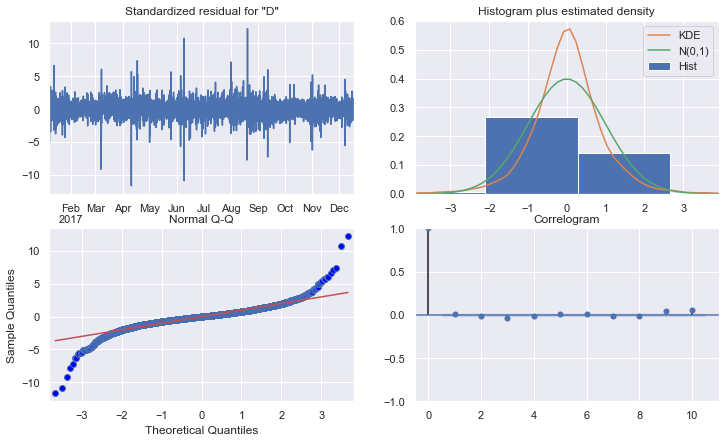

In [52]:
#Best model for the light car traffic: (1, 0, 0)(3, 1, 0), aic=94769.52128285923
model_opt = ARIMA(train['Date'], order=(1,0,0), seasonal_order=(3, 1, 0, 168), exog = train.drop(columns='Date'), trend='c')
results = model_opt.fit(method='innovations_mle', low_memory=True, cov_type='none')
_ = results.plot_diagnostics(figsize=(12, 7))

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


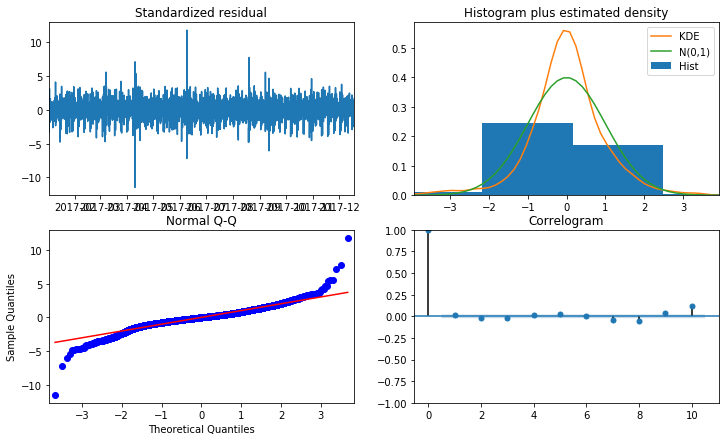

In [38]:
#results.fit(y_train_lag, exogenous= X_train_lag)
# Got the optimal SARIMAX order from running the above auto_arima function. It took more than 2 hours to get the optimal...
#...solution. So, just using the final values here
model_opt = SARIMAX(train['Date'], order=(2,0,0), seasonal_order=(2, 1, 0, 168), exog = train.drop(columns='Date'), trend='c')
results = model_opt.fit()
# plotting the residuals and checking if they meet the i.i.d (independent and identically distributed) requirements
_ = results.plot_diagnostics(figsize=(12, 7))

In [48]:
results.save('Models/SAIMAX_all_inner_lane.pkl')

In [40]:
residuals = pd.DataFrame(results.resid)

In [53]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              Date   No. Observations:                 8425
Model:             ARIMA(1, 0, 0)x(3, 1, 0, 168)   Log Likelihood              -47361.761
Date:                           Thu, 03 Dec 2020   AIC                          94757.521
Time:                                   09:42:56   BIC                          94876.841
Sample:                               01-01-2017   HQIC                         94798.298
                                    - 12-18-2017                                         
Covariance Type:                    Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0        nan        nan        nan         nan         nan
hour_sin1           0        nan        nan        nan         nan         nan
hour_cos1           0        nan        nan        nan         nan         nan
hour_sin2           0        nan        nan        nan         nan         nan
hour_cos2           0        nan        nan        nan         nan         nan
hour_sin3           0        nan        nan        nan         nan         nan
hour_cos3           0        nan        nan        nan         nan         nan
hour_sin4           0        nan        nan        nan         nan         nan
hour_cos4           0        nan        nan        nan         nan         nan
hour_sin5           0        nan        nan        nan         nan         nan
hour_cos5           0        nan        nan        nan         nan         nan
holiday             0        nan        nan        nan         nan         nan
ar.L1          0.8545        nan        nan        nan         nan         nan
ar.S.L168     -0.6967        nan        nan        nan         nan         nan
ar.S.L336     -0.3903        nan        nan        nan         nan         nan
ar.S.L504     -0.1856        nan        nan        nan         nan         nan
sigma2      5561.5164        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             68314.73
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.09
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [73]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                Date   No. Observations:                 8425
Model:             ARIMA(2, 0, 0)x(3, 1, [1], 168)   Log Likelihood              -47560.612
Date:                             Wed, 02 Dec 2020   AIC                          95171.223
Time:                                     18:35:07   BIC                          95346.694
Sample:                                 01-01-2017   HQIC                         95231.189
                                      - 12-18-2017                                         
Covariance Type:                      Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0        nan        nan        nan         nan         nan
week_sin1           0        nan        nan        nan         nan         nan
week_cos1           0        nan        nan        nan         nan         nan
week_sin2           0        nan        nan        nan         nan         nan
week_cos2           0        nan        nan        nan         nan         nan
week_sin3           0        nan        nan        nan         nan         nan
week_cos3           0        nan        nan        nan         nan         nan
hour_sin1           0        nan        nan        nan         nan         nan
hour_cos1           0        nan        nan        nan         nan         nan
hour_sin2           0        nan        nan        nan         nan         nan
hour_cos2           0        nan        nan        nan         nan         nan
hour_sin3           0        nan        nan        nan         nan         nan
hour_cos3           0        nan        nan        nan         nan         nan
hour_sin4           0        nan        nan        nan         nan         nan
hour_cos4           0        nan        nan        nan         nan         nan
hour_sin5           0        nan        nan        nan         nan         nan
hour_cos5           0        nan        nan        nan         nan         nan
holiday             0        nan        nan        nan         nan         nan
ar.L1          0.9016        nan        nan        nan         nan         nan
ar.L2         -0.0295        nan        nan        nan         nan         nan
ar.S.L168      0.1632        nan        nan        nan         nan         nan
ar.S.L336      0.1873        nan        nan        nan         nan         nan
ar.S.L504      0.0870        nan        nan        nan         nan         nan
ma.S.L168     -0.9991        nan        nan        nan         nan         nan
sigma2      5535.7143        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            204491.22
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.37
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              Date   No. Observations:                 8425
Model:             ARIMA(1, 0, 0)x(3, 1, 0, 168)   Log Likelihood              -47361.761
Date:                           Wed, 02 Dec 2020   AIC                          94769.521
Time:                                   09:37:55   BIC                          94930.954
Sample:                               01-01-2017   HQIC                         94824.690
                                    - 12-18-2017                                         
Covariance Type:                    Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0        nan        nan        nan         nan         nan
week_sin1           0        nan        nan        nan         nan         nan
week_cos1           0        nan        nan        nan         nan         nan
week_sin2           0        nan        nan        nan         nan         nan
week_cos2           0        nan        nan        nan         nan         nan
week_sin3           0        nan        nan        nan         nan         nan
week_cos3           0        nan        nan        nan         nan         nan
hour_sin1           0        nan        nan        nan         nan         nan
hour_cos1           0        nan        nan        nan         nan         nan
hour_sin2           0        nan        nan        nan         nan         nan
hour_cos2           0        nan        nan        nan         nan         nan
hour_sin3           0        nan        nan        nan         nan         nan
hour_cos3           0        nan        nan        nan         nan         nan
hour_sin4           0        nan        nan        nan         nan         nan
hour_cos4           0        nan        nan        nan         nan         nan
hour_sin5           0        nan        nan        nan         nan         nan
hour_cos5           0        nan        nan        nan         nan         nan
holiday             0        nan        nan        nan         nan         nan
ar.L1          0.8545        nan        nan        nan         nan         nan
ar.S.L168     -0.6967        nan        nan        nan         nan         nan
ar.S.L336     -0.3903        nan        nan        nan         nan         nan
ar.S.L504     -0.1856        nan        nan        nan         nan         nan
sigma2      5561.5164        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             68314.73
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.09
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Date   No. Observations:                 8425
Model:             SARIMAX(2, 0, 0)x(3, 1, 0, 24)   Log Likelihood              -50924.949
Date:                            Tue, 01 Dec 2020   AIC                         101897.898
Time:                                    15:55:42   BIC                         102066.764
Sample:                                01-01-2017   HQIC                        101955.557
                                     - 12-18-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2196      1.224      0.179      0.858      -2.179       2.619
week_sin1    -19.7413      6.112     -3.230      0.001     -31.720      -7.762
week_cos1    -14.8497      5.833     -2.546      0.011     -26.283      -3.417
week_sin2      0.7541      4.776      0.158      0.875      -8.606      10.114
week_cos2      4.1355      4.869      0.849      0.396      -5.408      13.679
week_sin3      1.0778      3.311      0.326      0.745      -5.412       7.568
week_cos3      3.8881      3.138      1.239      0.215      -2.263      10.039
hour_sin1      0.0180   1966.715   9.13e-06      1.000   -3854.673    3854.709
hour_cos1     -0.0338   1945.265  -1.74e-05      1.000   -3812.684    3812.616
hour_sin2     -0.0100   2276.592   -4.4e-06      1.000   -4462.048    4462.028
hour_cos2     -0.0165   2973.676  -5.53e-06      1.000   -5828.314    5828.281
hour_sin3      0.0077   2729.268   2.83e-06      1.000   -5349.259    5349.275
hour_cos3      0.0152   4003.789    3.8e-06      1.000   -7847.266    7847.297
hour_sin4      0.0101   3976.284   2.53e-06      1.000   -7793.362    7793.383
hour_cos4      0.0066   4473.002   1.48e-06      1.000   -8766.917    8766.930
hour_sin5     -0.0036   5245.092  -6.89e-07      1.000   -1.03e+04    1.03e+04
hour_cos5      0.0069   5463.510   1.27e-06      1.000   -1.07e+04    1.07e+04
holiday             0    146.379          0      1.000    -286.898     286.898
ar.L1          1.1246      0.005    204.876      0.000       1.114       1.135
ar.L2         -0.3419      0.006    -56.683      0.000      -0.354      -0.330
ar.S.L24      -0.5023      0.006    -80.225      0.000      -0.515      -0.490
ar.S.L48      -0.3724      0.008    -46.508      0.000      -0.388      -0.357
ar.S.L72      -0.2238      0.008    -28.953      0.000      -0.239      -0.209
sigma2      1.061e+04     76.317    139.083      0.000    1.05e+04    1.08e+04
===================================================================================
Ljung-Box (Q):                      528.15   Jarque-Bera (JB):             21331.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.12e+19. Standard errors may be unstable.
"""

In [54]:
#Now want to make predictions

forecast_1= results.predict(start=test.index[0], end=test.index[-1], exog=test.drop(columns='Date'))

In [47]:
forecast_1

2017-12-18 01:00:00    211.560005
2017-12-18 02:00:00    112.199966
2017-12-18 03:00:00     87.302840
2017-12-18 04:00:00     89.513163
2017-12-18 05:00:00    179.158091
                          ...    
2017-12-31 20:00:00    832.137926
2017-12-31 21:00:00    614.685706
2017-12-31 22:00:00    534.443528
2017-12-31 23:00:00    504.826537
2018-01-01 00:00:00    450.630364
Freq: H, Length: 336, dtype: float64

In [46]:
test['Date']

2017-12-18 01:00:00    154.0
2017-12-18 02:00:00     97.0
2017-12-18 03:00:00    103.0
2017-12-18 04:00:00    167.0
2017-12-18 05:00:00    398.0
                       ...  
2017-12-31 20:00:00    496.0
2017-12-31 21:00:00    276.0
2017-12-31 22:00:00    243.0
2017-12-31 23:00:00    216.0
2018-01-01 00:00:00     85.0
Freq: H, Name: Date, Length: 336, dtype: float64

In [111]:
#Convert forcast back to actual data, undo the differencing from the week data
bef_diff = df_no_week.tail(336)
fore_con = np.r_[bef_diff, forecast_1].cumsum().astype(float)

In [114]:
bef_diff

2017-12-18 01:00:00   -129.0
2017-12-18 02:00:00    -57.0
2017-12-18 03:00:00    -49.0
2017-12-18 04:00:00    -41.0
2017-12-18 05:00:00     36.0
                       ...  
2017-12-31 20:00:00     93.0
2017-12-31 21:00:00      2.0
2017-12-31 22:00:00    -97.0
2017-12-31 23:00:00   -204.0
2018-01-01 00:00:00   -347.0
Freq: H, Name: Date, Length: 336, dtype: float64

In [46]:
pm.arima.ndiffs(df_nan.diff().fillna(0))

0

In [138]:
df_no_week = df_nan.diff(168)

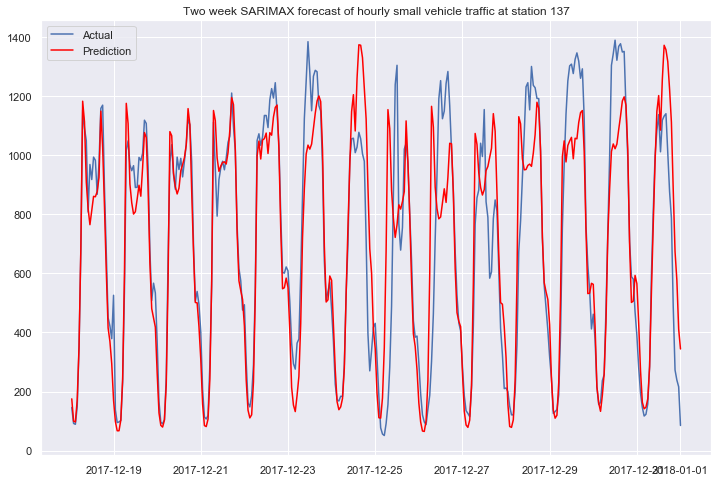

In [55]:
plt.plot(test['Date'], label='Actual')
#plt.plot(df_no_week.tail(336))
plt.plot(forecast_1, color='red', label='Prediction')
#plt.plot(test['Date']-forecast_1, color='purple', label='Residuals')
plt.legend()
plt.title('Two week SARIMAX forecast of hourly small vehicle traffic at station 137')
plt.show()

In [43]:
mape_score = (abs(test['Date']-forecast_1)/test['Date'])*100
mape_mean = mape_score.mean()

In [44]:
mape_mean

28.062170841324296

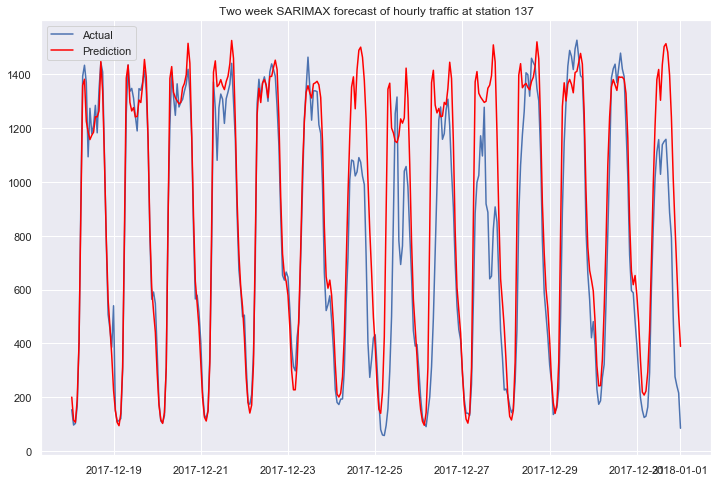

In [75]:
plt.plot(test['Date'], label='Actual')
#plt.plot(df_no_week.tail(336))
plt.plot(forecast_1, color='red', label='Prediction')
plt.legend()
plt.title('Two week SARIMAX forecast of hourly traffic at station 137')
plt.show()

In [76]:
mape_score = (abs(test['Date']-forecast_1)/test['Date'])*100
mape_score.mean()

33.49121284773993

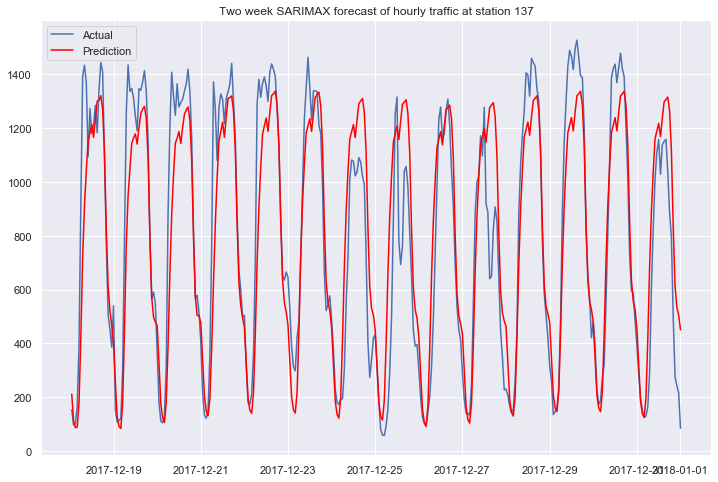

In [43]:
plt.plot(test['Date'], label='Actual')
#plt.plot(df_no_week.tail(336))
plt.plot(forecast_1, color='red', label='Prediction')
plt.legend()
plt.title('Two week SARIMAX forecast of hourly traffic at station 137')
plt.show()

In [44]:
mape_score = (abs(test['Date']-forecast_1)/test['Date'])*100
mape_mean = mape_score.mean()

In [45]:
mape_mean

28.09343248209575

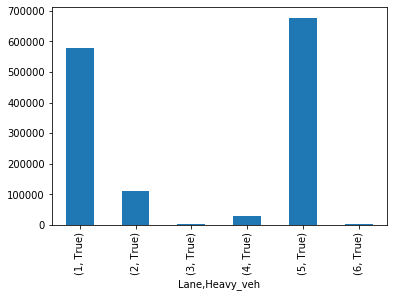

In [33]:
df_heavy.plot.bar()

In [24]:
plt.show()

In [3]:
WIMstation = "Ceneri"
start_year = 2011
end_year = 2019

In [12]:
df_WIM = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(WIMstation, start_year, end_year))

In [13]:
df_WIM.head()

,FS,GW_TOT,CLASS,ZST,LENTH,CS,Date
0,4,3500,0,408,674,5,2011-01-01 00:54:14
1,4,5270,0,408,839,8,2011-01-01 00:54:48
2,4,19280,12,408,1429,10,2011-01-01 02:43:02
3,4,4400,0,408,742,5,2011-01-01 02:54:33
4,4,4090,0,408,819,8,2011-01-01 03:12:30


In [14]:
df_WIM = df_WIM[df_WIM.Date.dt.year == 2017]

In [15]:
df_WIM.head()

,FS,GW_TOT,CLASS,ZST,LENTH,CS,Date
9160343,4,3570,0,408,1066,6,2017-01-01 00:28:57
9160344,3,3550,0,408,450,3,2017-01-01 00:52:52
9160345,3,4360,0,408,462,3,2017-01-01 01:20:47
9160346,4,19990,12,408,1434,10,2017-01-01 01:22:18
9160347,3,3550,0,408,423,3,2017-01-01 02:02:02


In [16]:
df_WIM = df_WIM.groupby('FS').Date.count()

In [17]:
df_WIM.head()

FS
1    654315
2     87325
3    115829
4    769014
Name: Date, dtype: int64

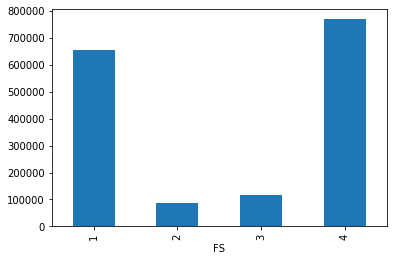

In [18]:
df_WIM.plot.bar()

Based on the above graph and the graph from the lanes in the circulation data, it can be seen that based on the number of heavy vehicles in 2017 at Ceneri passing by lane, that: circ lane 1 is WIM lane 1, circ lane 5 is WIM lane 4. Because these are the inner most lanes they are the ones that will be focused on.

Now looking at these inner two lanes, I will find the car rate per hour.

In [23]:
df_light = df[~df['Heavy_veh']]

In [24]:
inner_lanes = [1, 5] #As states above, these were found to be the inner lanes

In [26]:
df_inner = df_light[df_light.Lane.isin(inner_lanes)]

In [42]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=13)

C:\Users\Isabelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Isabelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Isabelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/137/Daily_count_season.png'

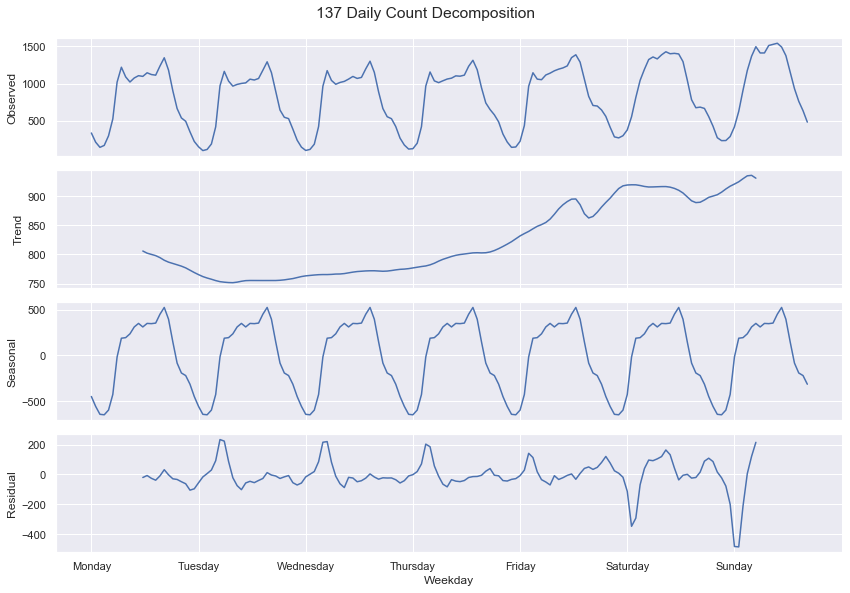

In [36]:
count_seasonality_circ(df_inner, station, year, 'Daily', False)

In [35]:
def count_seasonality_circ(df_inner, station, year, seasonality, pickle):
    if seasonality == 'Daily':
        frequency = 24
        truck_count = 'Weekday'
        seasonal = 'Date_d'
        precision = 'Hour'
        
    elif seasonality == 'Weekly':
        frequency = 7
        truck_count = 'Day of year'
        seasonal = 'Date_d'
        precision = 'Date_d'
        months = [3, 4, 5] #Taking months March, April, May
    
    #Get the general truck data for normalization
    #df_inner = pd.read_pickle('{}Data/{}_{}_datetime_h{}.pkl'.format(station, start_year, end_year, headway))
    df_inner['Weekday'] = df_inner.Date.dt.weekday
    df_inner['Hour'] = df_inner.Date.dt.hour
    df_inner['Date_d'] = df_inner.Date.dt.date
    df_inner['Day of year'] = df_inner.Date.dt.dayofyear
    df_inner['Year'] = df_inner.Date.dt.year

    if seasonality == 'Weekly':
        df_inner_hour = df_inner.groupby([truck_count]).Date.count().reset_index().rename(columns={'Date':'count'})
    
    elif seasonality == 'Daily':
        #if minute:
         #   df_platoon['Minute'] = df_platoon.Date.dt.minute
         #   df_platoon_hour = df_platoon.groupby([truck_count, precision, 'Minute']).Date.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour
        #else:
        df_inner_hour = df_inner.groupby([truck_count,precision]).Date.count().reset_index().rename(columns={'Date':'count'}) #Total count by weekday/hour

    df_inner_date = df_inner.groupby([truck_count])[seasonal].nunique().reset_index().rename(columns={seasonal:'seasonal_count'}) #Total days by weekday represented
    df_inner_grouped = df_inner_date.merge(df_inner_hour, on=truck_count)
    df_inner_grouped = df_inner_grouped.set_index(truck_count)
    
    #Normalizing
    df_inner_grouped['norm_count'] = df_inner_grouped['count']/df_inner_grouped['seasonal_count']
    
    #Renaming days of the week
    if seasonality == 'Daily':
        df_inner_grouped = df_inner_grouped.rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                     5: 'Saturday', 6:'Sunday'})
    
    if pickle:
        df_inner_grouped.to_pickle('{}/car_inner_{}_seasonality_{}.pkl'.format(station, seasonality, year))
    else:
        #Plotting
        #df_platoon_grouped.norm_count.plot(title="{} Normalized Natural Truck Platoon with at least 2, count by hour".format(station))
        result = seasonal_decompose(df_inner_grouped.norm_count, model='additive', freq=frequency)
        fig = result.plot()

        fig.suptitle('{} {} Count Decomposition'.format(station, seasonality), y=1.03)

        fig.savefig('Figures/{}/{}_count_season.png'.format(station, seasonality), bbox_inches='tight')

        plt.show()    